# **Klasifikace dat Sentinel-2**
## 155UZPR - Katedra Geomatiky - Fsv ČVUT
### Tereza Černohousová - Matěj Klimeš
### ZS2024

#### Abstrakt: 
Projekt se bude zabývat automatickým stažením dat Sentinel-2, jejich předzpracováním (včetně výpočtu spektrálních indexů) a následnou klasifikací a vizualizací výsledků.

#### Použité zdroje dat:

- **ČÚZK:** [data250](https://openzu.cuzk.cz/opendata/Data250/epsg-5514/data250.zip)


- **Copernicus** - data se stahují [zde](https://browser.dataspace.copernicus.eu/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=U2FsdGVkX1888xabjwJgGfFWUz1QeQbEfTmNjzRkDZhrBA6JYXklmmdldvnXcf3CcIdKsvZK19Jd8PkUP9CZvOB5xMUeMJyMrXKgklCl2959uBjnlMf8s%2BbI2PiPhD77&datasetId=S2_L1C_CDAS&fromTime=2023-02-07T00%3A00%3A00.000Z&toTime=2023-02-07T23%3A59%3A59.999Z&layerId=1_TRUE_COLOR&demSource3D=%22MAPZEN%22&cloudCoverage=10&dateMode=SINGLE)

#### Použité zdroje informací:
- **materiály ze cvičení UZPR:** [zde](https://geo.fsv.cvut.cz/vyuka/155uzpr/geopython/05_rasterio_sentinel.html)
- **Dokumentace knihoven:** [geopandas](https://geopandas.org/en/stable/), [eodag](https://eodag.readthedocs.io/en/stable/), [matplotlib](https://matplotlib.org/stable/index.html), [rasterio](https://rasterio.readthedocs.io/en/stable/), [scikit-learn](https://scikit-learn.org/stable/)
- **Chat GPT:** [zde](https://chatgpt.com/)

#### Import knihoven

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
import os
from eodag import EODataAccessGateway
import numpy as np
import rasterio as rio
import rasterio.mask as mask
from sklearn.cluster import KMeans 
import getpass

## 1 - Uživatelský vstup

**Požadované parametry:**
   - obec zájmu pro klasifikaci (např. Žamberk)
   
   - počáteční datum pro vyhledání dat Sentinel-2 (např. 2024-10-01)
    
   - koncové datum pro vyhledání dat Sentinel-2 (např. 2024-10-23)
    
   - přihlašovací jméno pro Copernicus (registrace [zde](https://identity.dataspace.copernicus.eu/auth/realms/CDSE/login-actions/registration?client_id=sh-5f8b630b-b083-49ed-b340-b8f01ecb81c4&tab_id=pGc2-WJcHvg))
    
   - heslo

In [2]:
def get_user_input():
    # Zadání názvu obce
    obec_zajmu = input("Zadejte název obce, pro kterou bude klasifikace zpracována: ")

    # Zadání časového období
    start = input("Zadejte počáteční datum, od kterého chcete data Sentinel 2 vyhledat (ve formátu RRRR-MM-DD): ")
    end = input("Zadejte koncové datum, ke kterému chcete data Sentinel 2 vyhledat (ve formátu RRRR-MM-DD): ")

    # Zadání přihlašovacích údajů pro Copernicus
    username = input("Zadejte uživatelské jméno pro přístup k Copernicus: ")
    password = getpass.getpass("Zadejte heslo pro přístup k Copernicus: ")

    # kontrola zadání všech parametrů a případné volání funkce znovu
    if not obec_zajmu or not start or not end or not username or not password:
        print("Všechna pole musí být vyplněna. Zkuste to znovu.")
        return get_user_input()

    return {
        "obec_zajmu": obec_zajmu,
        "start": start,
        "end": end,
        "username": username,
        "password": password,
    }


info = get_user_input()
obec_zajmu = info["obec_zajmu"]
start = info['start']
end = info['end']
username = info['username']
password = info['password']
# Jaký produkt Sentinel 2 chceme nenecháváme na uživateli - chceme s atmosférickými korekcemi - L2A
product = "S2_MSI_L2A" 

## 2 - Stažení a příprava oblasti zájmu z data250

Tato část přebírá kroky ze cvičení [UZPR](https://geo.fsv.cvut.cz/vyuka/155uzpr/geopython/05_rasterio_sentinel.html)
změnou oproti cvičení je automatické stažení a otevření pomocí geopandas, nikoli fiona

In [3]:
# Cílový adresář
zip_filename = "data250.zip"
# URL se zdrojem dat .shp
url = "https://openzu.cuzk.cz/opendata/Data250/epsg-5514/data250.zip"

# Stažení souboru ZIP pouze pokud dosud neexistuje
if not os.path.exists(zip_filename):  # Kontrola, zda soubor již existuje
    print(f"ZIP soubor {zip_filename} neexistuje, stahuji data...")  # Informace o stahování
    urllib.request.urlretrieve(url, zip_filename)  # Stažení souboru z dané URL
    print(f"Soubor {zip_filename} byl úspěšně stažen.")  # Potvrzení úspěšného stažení
else:
    print(f"ZIP soubor {zip_filename} již existuje. Stažení přeskočeno.")  # Informace o přeskakování stahování


ZIP soubor data250.zip již existuje. Stažení přeskočeno.


#### Import vrstvi obcí ze staženého ZIPu

In [4]:
obce = gpd.read_file("data250.zip!/PolbndMunDA.shp") #!/ - nemusíme extrahovat soubory
obce.head()

,FCSUBTYPE,F_CODE,ICC,SHN0,SHN1,SHN2,SHN3,TAA,ICOB,NUTS3,ISN,NAMN,DESN,SHAPE_Leng,SHAPE_Area,geometry
0,1,FA001,CZ,CZ0000000000,CZ0100000000,UNK,CZ0100554782,1,554782,CZ010,4605,Praha,obec,157071.726075,4.963111e+08,"POLYGON ((-733582.756 -1034199.856, -733690.30..."
1,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201513482,1,513482,CZ020,4605,Vysoký Újezd,obec,13689.999181,4.064693e+06,"POLYGON ((-742125.829 -1072463.392, -742056.67..."
2,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529303,1,529303,CZ020,4605,Benešov,obec,54242.943513,4.682135e+07,"POLYGON ((-729711.586 -1073957.287, -729679.83..."
3,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529451,1,529451,CZ020,4605,Bystřice,obec,64917.905895,6.343932e+07,"POLYGON ((-730989.011 -1081012.603, -731007.23..."
4,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529478,1,529478,CZ020,4605,Čakov,obec,13297.559487,5.318608e+06,"POLYGON ((-716606.98 -1075299.75, -716493.11 -..."


#### Výběr geometrie pro zadanou oblast

In [5]:
aoi = obce[obce["NAMN"] == obec_zajmu]["geometry"]

#### Zobrazení oblasti

<Axes: title={'center': 'Hranice obce Katovice'}>

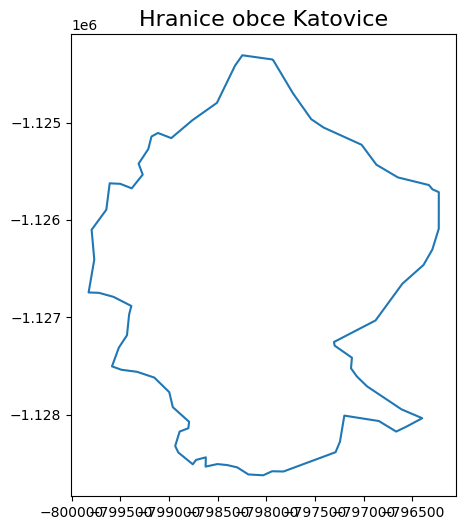

In [6]:
# Vytvoření grafu
figure, ax = plt.subplots(figsize=(6, 6))

# Nastavení názvu grafu s názvem obce
ax.set_title(f"Hranice obce {obec_zajmu}", fontsize=16)

# Načtení a vykreslení hranic obce z objektu 'aoi' na daný graf
aoi.boundary.plot(ax=ax)


#### Nastavení souřadnicového systému na S-JTSK

In [7]:
# Nastavení souřadnicového systému pro objekty v 'aoi' na EPSG:5514
aoi_map = aoi.set_crs(epsg=5514)

# Zobrazení hranic obce pomocí interaktivního nástroje 'explore'
aoi_map.boundary.explore()

## 3 - Stažení dat Sentinel 2

Tato část přebírá kroky ze cvičení [UZPR](https://geo.fsv.cvut.cz/vyuka/155uzpr/geopython/05_rasterio_sentinel.html)

#### Vytvoření přístupu k datům Sentinel 2 pomocí eodag

In [8]:
# Vytvoření EODataAccessGateway pro přístup k datům
dag = EODataAccessGateway()
# Získání dostupných poskytovatelů dat pro daný produkt
dag.available_providers(product)

geodes skipped: could not be loaded from user configuration


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xec in position 786: invalid continuation byte

#### Vyhledání produktů pro rozsah a období zadané uživatelem

In [9]:
# Převod geometrie oblasti zájmu (AOI) na souřadnicový systém EPSG:4326 (WGS 84)
# a získání celkových hranic (bounding box) této oblasti ve formě n-tice
extent = tuple(aoi_map.to_crs(4326).total_bounds)

# Nastavení preferovaného poskytovatele dat na 'cop_dataspace'
dag.set_preferred_provider("cop_dataspace")

# Vyhledávání dat podle specifikovaných parametrů
results = dag.search(
    productType=product,  # Typ produktu (např. satelitní snímek)
    start=start,  # Začátek časového intervalu
    end=end,  # Konec časového intervalu
    geom=tuple(extent),  # Geometrie vyhledávání ve formě hranic AOI
    count=True  # Počet výsledků
)

# Výpis počtu nalezených záznamů (produktů) odpovídajících vyhledávání
print(results.number_matched)

14


#### Nalezené produkty - vybíráme s maximálním podílem mraků 15 %

In [10]:
results_cc = results.filter_property(operator="le", cloudCover=15) 
results_cc

SearchResult([EOProduct(id=S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420, provider=cop_dataspace)])

#### Úprava konfiguračního souboru - dodání přihlašovacích údajů

In [11]:
dag.update_providers_config(f"""
cop_dataspace:  
    download:  
        extract: False
        outputs_prefix: /tmp/sentinel  
        delete_archive: False  

    auth:  
        credentials:  
            username: {username}  
            password: {password}
""")


#### Vizualizace dat před stažením

quicklooks/S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420: 0.00B [00:00, ?B/s]


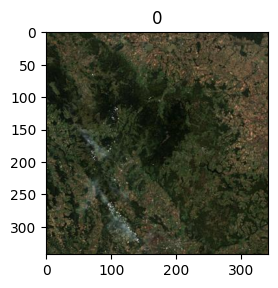

In [12]:
# Vytvoření grafu pro zobrazení více snímků
fig = plt.figure(figsize=(10, 8))  # Velikost obrázku (šířka 10, výška 8)

# Procházíme seznam 'results_cc', který obsahuje produkty (např. satelitní snímky)
for i, product in enumerate(results_cc, start=1):  # Začínáme indexovat od 1
    # Tato řádka se stará o stažení náhledového obrázku (quicklook) pro každý produkt
    quicklook_path = product.get_quicklook()  # Získání cesty k náhledovému obrázku

    # Načtení a zobrazení obrázku
    img = mpimg.imread(quicklook_path)  # Načteme obrázek z dané cesty
    ax = fig.add_subplot(3, 4, i)  # Vytvoříme podgraf v mřížce 3x4, pozice podle indexu 'i'

    # Nastavení titulku podgrafu, kde začínáme od 0
    ax.set_title(i - 1)  

    # Zobrazení obrázku v příslušném podgrafu
    plt.imshow(img)

# Úprava rozvržení pro správné zobrazení obrázků, aby se nepřekrývaly
plt.tight_layout()  


#### Stažení prvního produktu z nalezených

Dle dokumentace se soubor stáhne pouze pokud již nebyl stažen:

An EOProduct has a location attribute that stores either its remote location (before being downloaded) or its local location (after being downloaded). The download methods of eodag checks first wheter the product/quicklook to download has been already downloaded. If so, it just returns its path and does not try to download it again.

In [13]:
data_path = dag.download(results_cc[0])
data_path


0.00B [00:00, ?B/s]
S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420: 0.00B [00:00, ?B/s]
S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420: 0file [00:00, ?file/s]
S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420: 100%|███████████████████| 1/1 [00:00<00:00, 124.32file/s]


'C:\\Users\\terce\\AppData\\Local\\Temp\\S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420.SAFE.zip'

In [10]:
data_path = 'S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806.SAFE.zip'

## 4 - Analýza struktury a příprava stažených dat

#### Analýza základní struktury stažených dat

In [11]:
# Otevření
with rio.open(data_path) as ds:
    # Načteme seznam subdatasetů (pásma) z dat Sentinel-2
    sd = ds.subdatasets  # Seznam dostupných subdatasetů v datech Sentinel-2
    meta = ds.meta    
print(meta)
print(len(sd))

{'driver': 'SENTINEL2', 'dtype': 'float_', 'nodata': None, 'width': 512, 'height': 512, 'count': 0, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}
4


C:\skola\Čtvrťák\UZPR\UZPR_projekt\venv\Lib\site-packages\rasterio\__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


#### Prozkoumání dat s rozlišením 10 m

In [12]:
# otevření subdatasetu s pásmy, které mají rozlišení 10 m
with rio.open(sd[0]) as b10m:
    # vypsání základních informací - Souř. systém, Rozsah, počet
    print("CRS:", b10m.crs)
    print("Bounds:", b10m.bounds)
    print("Bands:", b10m.count)
    meta = b10m.meta
    for b in b10m.indexes:
        # výpis názvů pásem
        print(b, b10m.tags(b)["BANDNAME"])

CRS: EPSG:32633
Bounds: BoundingBox(left=399960.0, bottom=5390220.0, right=509760.0, top=5500020.0)
Bands: 6
1 B4
2 B3
3 B2
4 B8
5 AOT
6 WVP


#### Funkce pro oříznutí rastru

Funkce je částečně přebrata ze cvičení [UZPR](https://geo.fsv.cvut.cz/vyuka/155uzpr/geopython/05_rasterio_sentinel.html)
dále je ovšem rozšířena o volbu subdatasetu,  volbu využití Null nebo 0 a převod SS aoi

In [13]:
def clip_raster(data_path, aoi,subdataset_idx=0,use_null=0):
    with rio.open(data_path) as ds:
        with rio.open(ds.subdatasets[subdataset_idx]) as subdataset:
            aoi = aoi.to_crs(subdataset.crs)
            image, transform = rio.mask.mask(subdataset, aoi, crop=True)
            data = image.astype(float)
            if use_null:
                data[data == 0] = np.nan 
            return data, transform

#### Oříznutí dat dle vybrané oblasti zájmu (AOI)

In [14]:
# převod SS
aoi_utm = aoi_map.to_crs(b10m.crs)
# oříznutí dat z prvního subdatasetu
data_aoi, clip_transform = clip_raster(data_path, aoi_utm,use_null=0,subdataset_idx=0)
print('počet pásem, rozměry oříznutého rastru(počet řádků, počet sloupců): ',data_aoi.shape)

C:\skola\Čtvrťák\UZPR\UZPR_projekt\venv\Lib\site-packages\rasterio\__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


počet pásem, rozměry oříznutého rastru(počet řádků, počet sloupců):  (6, 427, 363)


#### Výběr R, G, B pásem a normalizace

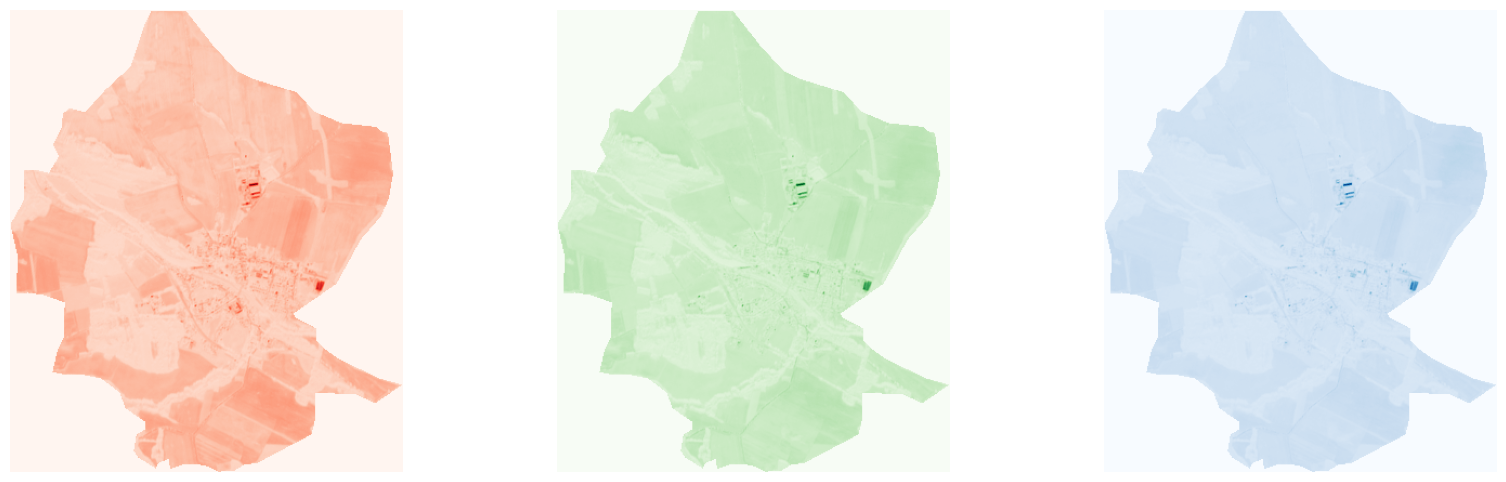

In [51]:
# výběr pásem R,G,B
red = data_aoi[0, :, :]
green = data_aoi[1, :, :]
blue = data_aoi[2, :, :]
# Normalizace hodnot do rozsahu 0-1 pro vizualizaci
def normalize(band):
    # Normalizace do rozsahu 0-1
    return (band - np.nanmin(band)) / (np.nanmax(band) - np.nanmin(band))

r_norm = normalize(red)
g_norm = normalize(green)
b_norm = normalize(blue)

fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(r_norm, cmap='Reds')
ax1.axis('off')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(g_norm, cmap='Greens')
ax2.axis('off')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(b_norm, cmap='Blues')
ax3.axis('off') 
plt.show()

#### Vytvoření RGB obrazu

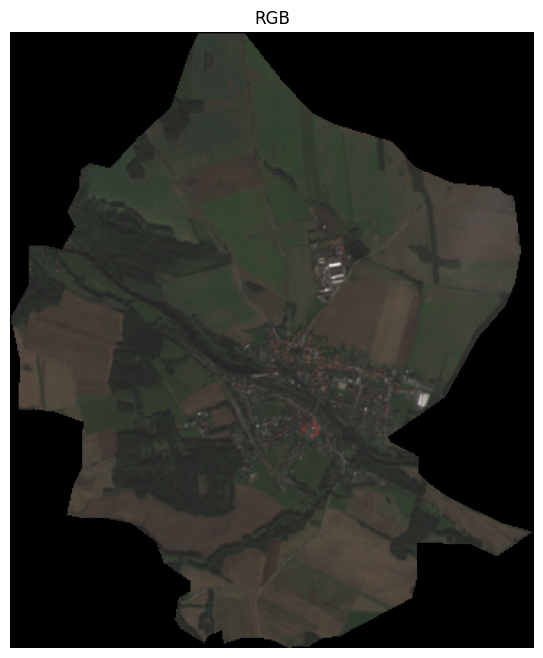

In [52]:
# Kombinace pásem do jednoho RGB obrazu
rgb_image = np.dstack([r_norm, g_norm, b_norm])
# Zobrazení
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("RGB")
plt.show()

## 5 - Výpočet spektrálních indexů

#### Funkce pro převzorkování pásem s rozdílným rozlišením

In [53]:
def resample_band(band, out_transform, target_height, target_width):
    # Importujeme potřebné knihovny
    from rasterio.io import MemoryFile  # Pro práci s virtuálními soubory v paměti
    from rasterio.enums import Resampling  # Pro metody převzorkování dat
    
    # Vytvoření virtuálního souboru pro zápis pásma
    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",  # Formát souboru (GeoTIFF)
            height=band.shape[0],  # Výška pásma (počet řádků)
            width=band.shape[1],  # Šířka pásma (počet sloupců)
            count=1,  # Počet kanálů (v tomto případě 1, protože máme jen jedno pásmo)
            dtype=band.dtype,  # Datový typ dat v pásmu
            transform=out_transform,  # Georeferencování (transformace) pásma
        ) as dataset:
            dataset.write(band, 1)  # Zapíšeme pásmo do virtuálního souboru

            # Resamplování pásma tak, aby odpovídalo cílovému rozlišení
            resampled_band = dataset.read(
                1,
                out_shape=(target_height, target_width),  # Cílové rozměry
                resampling=Resampling.bilinear,  # Použití bilineární interpolace pro převzorkování
            )
    return resampled_band  # Vrátíme převzorkované pásmo

#### Funkce pro výpočet spektrálních indexů (NDVI, NDWI, NDMI, AWEISh)

In [54]:
def SpectralIndexes(si, data_path, aoi):
    # Importujeme potřebné knihovny
    from rasterio.enums import Resampling  # Pro resamplování (převzorkování) dat
    from rasterio.io import MemoryFile  # Pro práci s virtuálními soubory v paměti

    # Oříznutí dat podle oblasti zájmu (AOI) pro první subdataset
    crop_sen_clip0, out_transform0 = clip_raster(data_path, aoi,subdataset_idx=0,use_null=1)
    crop_sen_clip1, out_transform1 = clip_raster(data_path, aoi,subdataset_idx=1,use_null=1)
    # Extrakce specifických pásem pro výpočty z oříznutých datasetů
    R = crop_sen_clip0[0]  # Červené pásmo (B4)
    G = crop_sen_clip0[1]  # Zelené pásmo (B3)
    B = crop_sen_clip0[2]  # Modré pásmo (B2)
    NIR = crop_sen_clip0[3]  # Pásmo blízké infračervené (B8)
    SWIR1 = crop_sen_clip1[4]  # Pásmo krátkovlnného infračerveného záření 1 (B11)
    SWIR2 = crop_sen_clip1[5]  # Pásmo krátkovlnného infračerveného záření 2 (B12)
    # # Resamplování SWIR1 tak, aby odpovídalo rozlišení pásma NIR
    # target_height, target_width = NIR.shape  # Získáme cílové rozlišení (výška a šířka) z pásma NIR
    # with MemoryFile() as memfile:
    #     with memfile.open(
    #         driver="GTiff",
    #         height=SWIR1.shape[0],
    #         width=SWIR1.shape[1],
    #         count=1,
    #         dtype=SWIR1.dtype,
    #         transform=out_transform1
    #     ) as dataset:
    #         dataset.write(SWIR1, 1)  # Zapíšeme pásmo SWIR1 do virtuálního souboru
    # 
    #         # Resamplování SWIR1 tak, aby odpovídalo rozlišení NIR pomocí bilineární interpolace
    #         swir1_resampled = dataset.read(
    #             1,
    #             out_shape=(target_height, target_width),
    #             resampling=Resampling.bilinear
    #         )

    # Resamplování pásma SWIR1 a SWIR2 tak, aby odpovídalo rozlišení NIR - 10 m
    target_height, target_width = NIR.shape
    SWIR1 = resample_band(SWIR1, out_transform1, int(target_height), int(target_width))
    SWIR2 = resample_band(SWIR2, out_transform1, int(target_height), int(target_width))
    # SWIR2 = normalize(SWIR2)
    # VÝPOČET INDEXU na základě zvoleného spektrálního indexu (si)
    if si == 'NDVI':  # Výpočet NDVI (Normalized Difference Vegetation Index)
        raster = (NIR - R) / (NIR + R)
    elif si == 'NDWI':  # Výpočet NDWI (Normalized Difference Water Index)
        raster = (G - NIR) / (G + NIR)
    elif si == 'NDMI':  # Výpočet NDMI (Normalized Difference Moisture Index)
        raster = (NIR - SWIR1) / (NIR + SWIR1)
    elif si == 'AWEISH':  # Výpočet AWEISH (Automated Water Extraction Index for Shadow)
        raster = B + 2.5 * G - 1.5 * (NIR + SWIR1) - 0.25 * SWIR2

    return raster  # Vrátíme vypočítaný rastr (spektrální index)

#### Výpočet a vizualizace spektrálních indexů 

In [44]:
AWEISh = SpectralIndexes('AWEISH', data_path, aoi_utm)
print(np.nanmin(AWEISh))

C:\skola\Čtvrťák\UZPR\UZPR_projekt\venv\Lib\site-packages\rasterio\__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\skola\Čtvrťák\UZPR\UZPR_projekt\venv\Lib\site-packages\rasterio\__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


-12399.420471480833


C:\skola\Čtvrťák\UZPR\UZPR_projekt\venv\Lib\site-packages\rasterio\__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\skola\Čtvrťák\UZPR\UZPR_projekt\venv\Lib\site-packages\rasterio\__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\skola\Čtvrťák\UZPR\UZPR_projekt\venv\Lib\site-packages\rasterio\__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\skola\Čtvrťák\UZPR\UZPR_projekt\venv\Lib\site-packages\rasterio\__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = Da

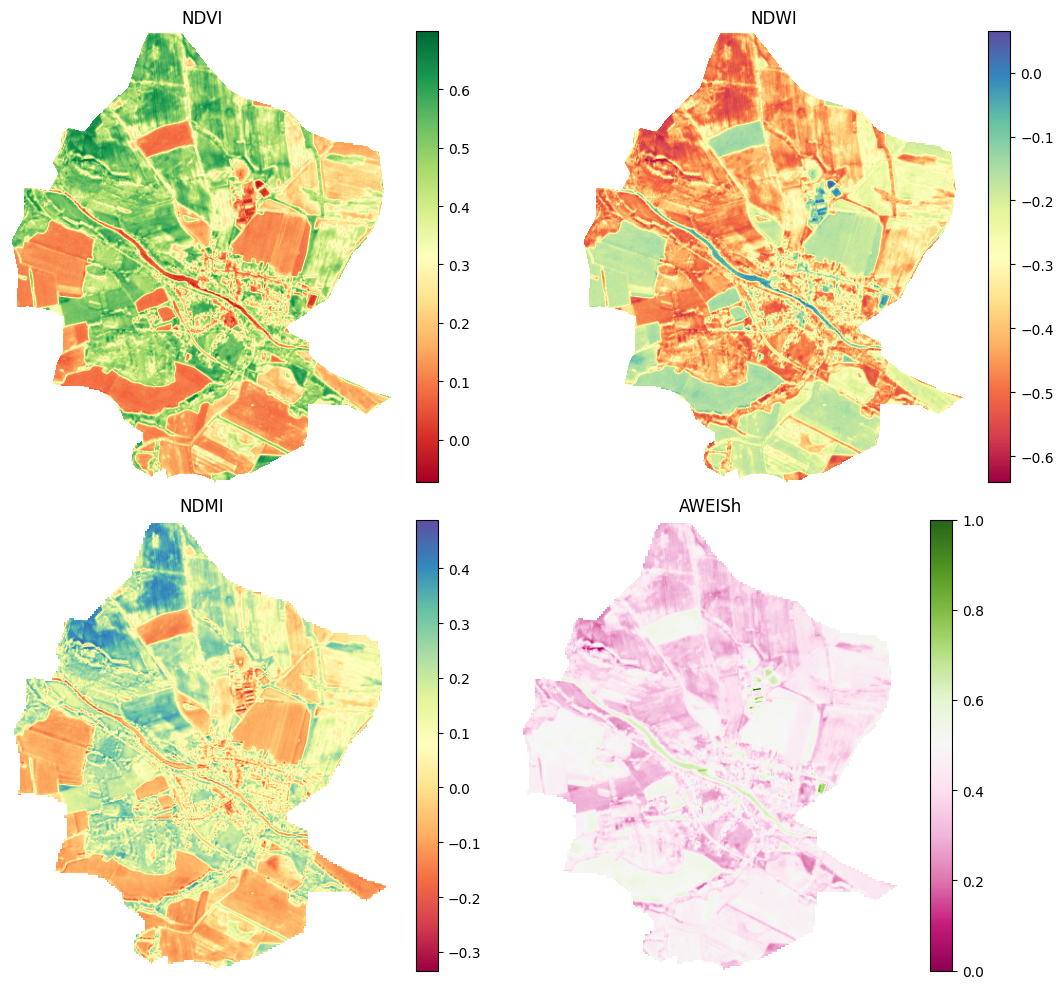

In [55]:
NDVI = SpectralIndexes('NDVI', data_path, aoi_utm)
NDWI = SpectralIndexes('NDWI', data_path, aoi_utm)
NDMI = SpectralIndexes('NDMI', data_path, aoi_utm)
AWEISh = SpectralIndexes('AWEISH', data_path, aoi_utm)


AWEIShn = normalize(AWEISh)


fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# 1 subplot
im1 = ax[0, 0].imshow(NDVI, cmap='RdYlGn')
ax[0, 0].set_title('NDVI')
ax[0, 0].axis('off')  # Skrytí os pro lepší vzhled
fig.colorbar(im1, ax=ax[0, 0], fraction=0.046, pad=0.04)  # Přidání colorbar

# 2 subplot
im2 = ax[0, 1].imshow(NDWI, cmap='Spectral')
ax[0, 1].set_title('NDWI')
ax[0, 1].axis('off')  # Skrytí os pro lepší vzhled
fig.colorbar(im2, ax=ax[0, 1], fraction=0.046, pad=0.04)  # Přidání colorbar

# 3 subplot
im3 = ax[1, 0].imshow(NDMI, cmap='Spectral')
ax[1, 0].set_title('NDMI')
ax[1, 0].axis('off')  # Skrytí os pro lepší vzhled
fig.colorbar(im3, ax=ax[1, 0], fraction=0.046, pad=0.04)  # Přidání colorbar

# 4 subplot

im4 = ax[1, 1].imshow(AWEIShn, cmap='PiYG')
ax[1, 1].set_title('AWEISh')
ax[1, 1].axis('off')  # Skrytí os pro lepší vzhled
cbar = fig.colorbar(im4, ax=ax[1, 1])  # Přidání colorbar
# cbar.ax.set_yticklabels(['nízká', 'vysoká'])
plt.tight_layout()  # Optimalizace rozmístění grafů
plt.show()


- **NDVI** (Normalized Difference Vegetation Index):  
  Používá se k monitorování vegetace, protože měří relativní množství chlorofylu v rostlinách na základě rozdílu mezi odrazem v blízké infračervené (NIR) a červené oblasti spektra.

- **NDWI** (Normalized Difference Water Index):  
  Určen k detekci vodních ploch a sleduje obsah vlhkosti na povrchu Země, přičemž využívá zelený a blízký infračervený (NIR) kanál.

- **NDMI** (Normalized Difference Moisture Index):  
  Měří vlhkost vegetace pomocí rozdílu mezi blízkou infračervenou (NIR) a středně infračervenou (SWIR) oblastí spektra.

- **AWEIsh** (Automated Water Extraction Index - shadow):  
  Speciální index navržený pro detekci vody, který minimalizuje vliv stínu, sněhu a jiných odrazů na vodních plochách. Verze AWEIsh (sh = shadow) se zaměřuje na eliminaci vlivu stínu.

## 6 - Neřízená klasifikace

#### Převod dat s rozlišením 10 m na 2D matici
Výsledkem je matice kde sloupce označují pásma a v řádcích jsou hodnoty pixelů 

In [ ]:
data_aoi2, clip_transform = clip_raster(data_path, aoi_utm,use_null=1,subdataset_idx=0)
# Převod dat na 2D matici
data_2d = data_aoi2.reshape(data_aoi2.shape[0], -1).T  # Přeformátujeme data na 2D
mask_valid = ~np.isnan(data_2d).any(axis=1)  # Vytvoříme masku platných dat (bez NaN)
data_2d_valid = data_2d[mask_valid]  # Aplikujeme masku
print(data_2d_valid.shape)

Dále je potřeba odstranit NaN hodnoty

In [ ]:
mask_valid = ~np.isnan(data_2d).any(axis=1)  # Vytvoříme masku platných dat (bez NaN)
data_2d_valid = data_2d[mask_valid]  # Aplikujeme masku

#### Neřízená klasifikace pomocí KMeans

In [ ]:
# Počet klastrů
#n_clusters = 4  # Např. voda, vegetace, město, zemědělská půda
n_clusters = 15

# Inicializace K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit modelu na platných datech
kmeans.fit(data_2d_valid)

# Získání výsledků a vytvoření klasifikovaného obrazu
labels = np.full(data_2d.shape[0], np.nan)  # Inicializace výsledků s NaN
labels[mask_valid] = kmeans.labels_  # Přiřazení výsledků pouze platným datům


#### Zobrazení KMeans klasifikovaného rastru

In [ ]:
# Převod výsledků zpět na 2D obraz (tvar: [výška, šířka])
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap
labels_2d = labels.reshape(data_aoi.shape[1], data_aoi.shape[2])


# Definice colormap pro n klastrů
cmap = plt.colormaps['tab20']  # Použití palety
cmap = ListedColormap(cmap(np.linspace(0, 1, n_clusters)))

# Normalizace pro diskrétní hodnoty
norm = BoundaryNorm(boundaries=np.arange(n_clusters+1)-0.5, ncolors=n_clusters)

# Vykreslení mapy s colorbarem
plt.figure(figsize=(8,8))
plt.imshow(labels_2d, cmap=cmap, norm=norm)
plt.colorbar(label='Klastry', ticks=np.arange(n_clusters))

# Titulek
plt.title('K-means klasifikace')
plt.show()


#### Maskování pomocí NDVI - vytvoření kategorií, sestavení masky a vizualizace

In [94]:
# 3. Vytvoření masek na základě NDVI
maska_voda = (NDVI >= -1) & (NDVI < 0)
maska_puda = (NDVI >= 0) & (NDVI < 0.3)
maska_stredni_vegetace = (NDVI >= 0.3) & (NDVI < 0.5)
maska_husta_vegetace = (NDVI >= 0.5) & (NDVI <= 1)

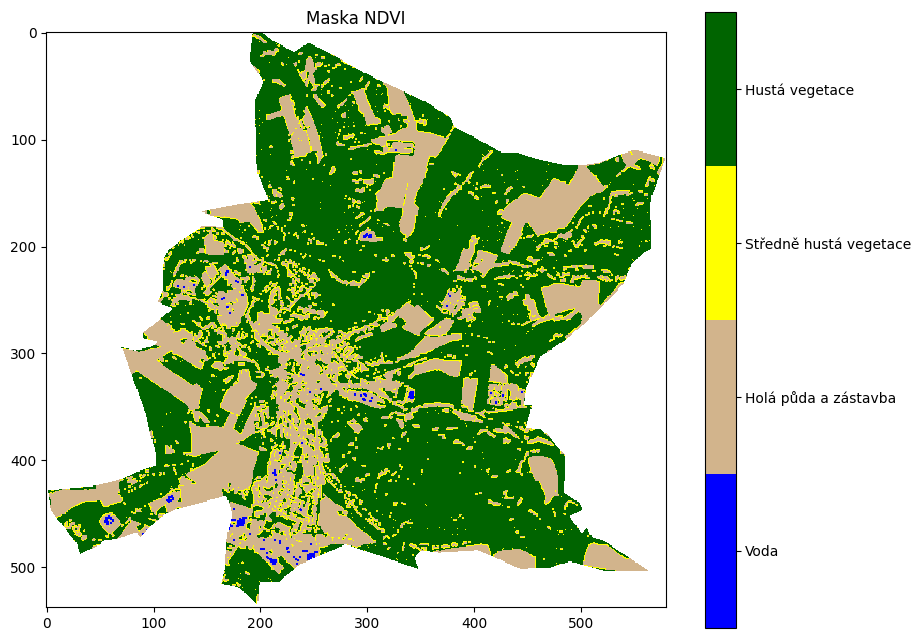

In [95]:
# 2. Vytvoření kombinovaného rastru
# Použijeme hodnoty v labels_2d a přidáme informaci z NDVI masek
combined_raster = np.full_like(NDVI, np.nan, dtype=np.float32)
# Naplnění kombinovaného rastru na základě masek NDVI
combined_raster[maska_voda] = 1  # Voda
combined_raster[maska_puda] = 2  # Půda
#combined_raster[maska_ridka_vegetace] = 3  # Řídká vegetace
combined_raster[maska_stredni_vegetace] = 4  # Střední vegetace
combined_raster[maska_husta_vegetace] = 5  # Hustá vegetace

from matplotlib.colors import ListedColormap
# 1. Definice vlastní barevné mapy pro 5 kategorií
colors = ['blue', 'tan', 'yellow', 'darkgreen']
#colors = ['white', 'blue', 'tan', 'yellow', 'darkgreen'] 
cmap1 = ListedColormap(colors)

# Zobrazení kombinovaného rastru
fig, ax = plt.subplots(figsize=(10, 8))  # Vytvoření figure a osy
im = ax.imshow(combined_raster, cmap=cmap1)

# Přidání barevné legendy s názvy kategorií
cbar = fig.colorbar(im, ax=ax, ticks=[1.5, 2.5, 3.5, 4.5])  # Ticks podle hodnot v kombinovaném rastru
#cbar.set_label('Kategorie', rotation=270, labelpad=30)
cbar.set_ticklabels(['Voda', 'Holá půda a zástavba', 'Středně hustá vegetace', 'Hustá vegetace'])  # Názvy kategorií

# Nastavení titulu a zobrazení grafu
ax.set_title("Maska NDVI")
plt.show()


#### Aplikace masky na klasifikovaný rastr

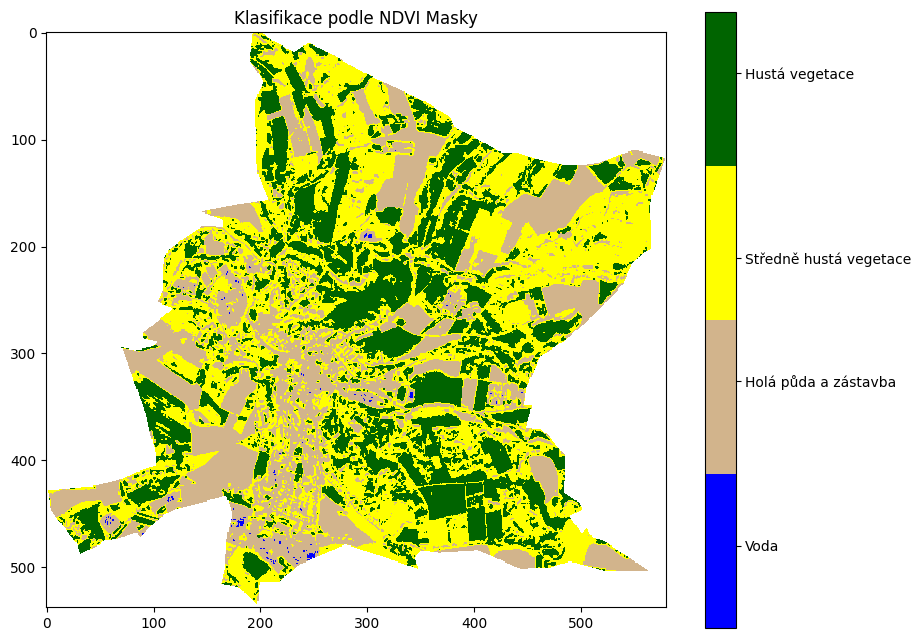

In [97]:
# Předpokládané data
rastr_klasifikace = labels_2d
# Definice masek pro různé oblasti podle NDVI
maska_voda = (NDVI >= -1) & (NDVI < 0)
maska_ridka_vegetace = (NDVI >= 0) & (NDVI < 0.3)
maska_stredni_vegetace = (NDVI >= 0.3) & (NDVI < 0.5)
maska_husta_vegetace = (NDVI >= 0.5) & (NDVI <= 1)

# Úprava klasifikovaného rastrového obrazu na základě NDVI
# Přiřazení hodnot z NDVI na základě masky
# Například pro oblast s vodou nastavíme klasifikaci na 0 (můžete si přizpůsobit hodnoty podle potřeby)
rastr_klasifikace[maska_voda] = 0  # Voda
rastr_klasifikace[maska_ridka_vegetace] = 1  # Řídká vegetace
rastr_klasifikace[maska_stredni_vegetace] = 2  # Střední vegetace
rastr_klasifikace[maska_husta_vegetace] = 3  # Hustá vegetace

# Vytvoření diskrétní colormap pro klasifikaci
colors = ['blue', 'tan', 'yellow', 'darkgreen']  # Barvy pro různé oblasti
cmap = ListedColormap(colors)

# Normalizace pro zobrazení
norm = BoundaryNorm(boundaries=np.arange(5)-0.5, ncolors=5)

# Vykreslení mapy s barvami pro každý klastra a typ pokrytí
# plt.figure(figsize=(8,8))
# plt.imshow(rastr_klasifikace, cmap=cmap, norm=norm)
fig, ax = plt.subplots(figsize=(10, 8))  # Vytvoření figure a osy
im = ax.imshow(rastr_klasifikace, cmap=cmap)

# Přidání colorbaru a titulu
cbar = plt.colorbar(im, ax=ax)  # Vytvoření colorbaru z obrazového objektu 'im'
cbar.set_ticks([0.4, 1.2, 1.8, 2.7])
cbar.set_ticklabels(['Voda', 'Holá půda a zástavba', 'Středně hustá vegetace', 'Hustá vegetace'])
ax.set_title('Klasifikace podle NDVI Masky')
plt.show()


Znovu výpočet K-Means, nyní 4 klastry. Vidíme, že výsledky jsou shodné, ale bez znalosti oblasti nevíme, který klastr odpovídá kterému typu povrchu

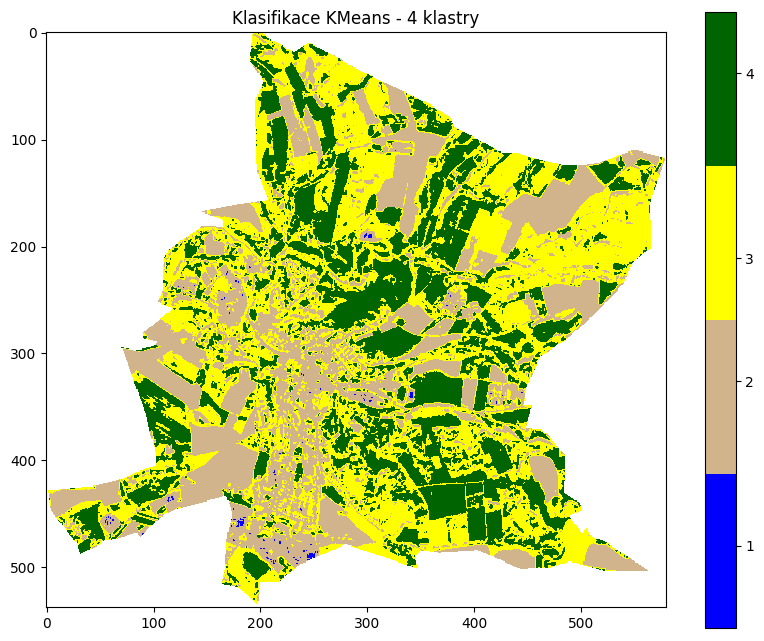

In [98]:
# Počet klastrů
n_clusters = 4

# Inicializace K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit modelu na platných datech
kmeans.fit(data_2d_valid)

# Získání výsledků a vytvoření klasifikovaného obrazu
labels2 = np.full(data_2d.shape[0], np.nan)  # Inicializace výsledků s NaN
labels2[mask_valid] = kmeans.labels_  # Přiřazení výsledků pouze platným datům
# Převod výsledků zpět na 2D obraz (tvar: [výška, šířka])
labels_2d_2 = labels.reshape(data_aoi.shape[1], data_aoi.shape[2])

# Definice colormap pro n klastrů
colors = ['blue', 'tan', 'yellow', 'darkgreen']  # Barvy pro různé oblasti
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(10, 8))  # Vytvoření figure a osy
im = ax.imshow(labels_2d_2, cmap=cmap)

# Přidání colorbaru a titulu
cbar = plt.colorbar(im, ax=ax)  # Vytvoření colorbaru z obrazového objektu 'im'
cbar.set_ticks([0.4, 1.2, 1.8, 2.7])
cbar.set_ticklabels(['1','2','3','4'])
ax.set_title('Klasifikace KMeans - 4 klastry')
plt.show()


RGB pro porovnání

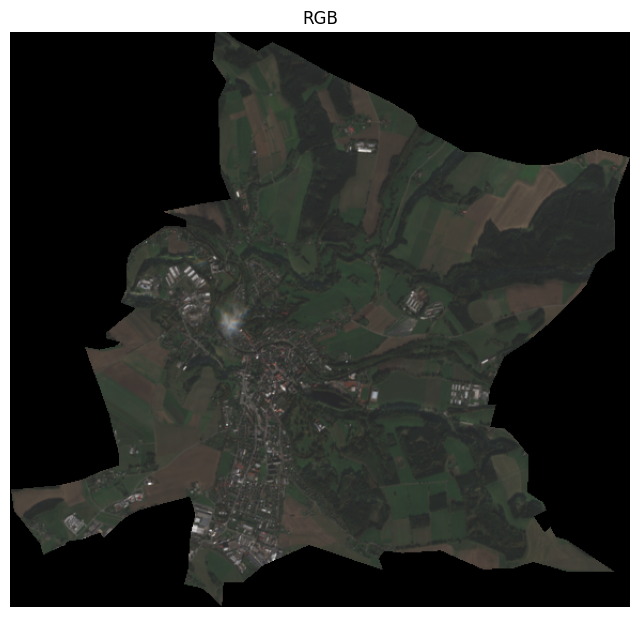

In [51]:
# Zobrazení RGB pro porovnání
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("RGB")
plt.show()